# AAut lab question 2 part 1

## Image classification

# Initial steps
Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import random
from PIL import Image, ImageEnhance
from sklearn.model_selection import KFold

Load data

In [2]:
Xtest1 = np.load('Xtest1.npy')
Xtrain1 = np.load('Xtrain1.npy')
Xtrain1_extra = np.load('Xtrain1_extra.npy')
Ytrain1 = np.load('Ytrain1.npy')

In [23]:
def augment_images(images, labels):
    augmented_images = []
    augmented_labels = []

    # Reshape the images from (2783, 2304) to (2783, 48, 48)
    reshaped_images = images.reshape(-1, 48, 48)

    for img, label in zip(reshaped_images, labels):
        pil_img = Image.fromarray(img)

        # Original image
        augmented_images.append(np.array(pil_img))
        # Horizontal flip
        augmented_images.append(np.array(pil_img.transpose(Image.FLIP_LEFT_RIGHT)))
        # Vertical flip
        augmented_images.append(np.array(pil_img.transpose(Image.FLIP_TOP_BOTTOM)))
        # Rotate 90 degrees
        augmented_images.append(np.array(pil_img.rotate(90)))

        if label == 0:
            # Rotate 180 degrees
            augmented_images.append(np.array(pil_img.rotate(180)))
            # Rotate 270 degrees
            augmented_images.append(np.array(pil_img.rotate(270)))
            # Increase the brightness
            augmented_images.append(np.array(ImageEnhance.Brightness(pil_img).enhance(1.5)))
            # Append the label for each augmented image
            augmented_labels.extend([label] * 7)
        else:
            # Append the label for each augmented image
            augmented_labels.extend([label] * 4)

    # Convert the augmented images back to the (num_images, 2304) format
    augmented_images = np.array(augmented_images).reshape(-1, 48 * 48)
    return augmented_images, augmented_labels

In [19]:
# Function to plot images
def plot_images(images, labels, num_images=20, extra=0):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i].reshape(48, 48), cmap='gray')
        if extra:
            plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

Augment data

(2783, 2304)
(14150, 48, 48, 1)
[0 1 1 ... 0 0 1]
Quantity of 0s: 1006
Quantity of 1s: 1777
Quantity of 0s: 7042
Quantity of 1s: 7108


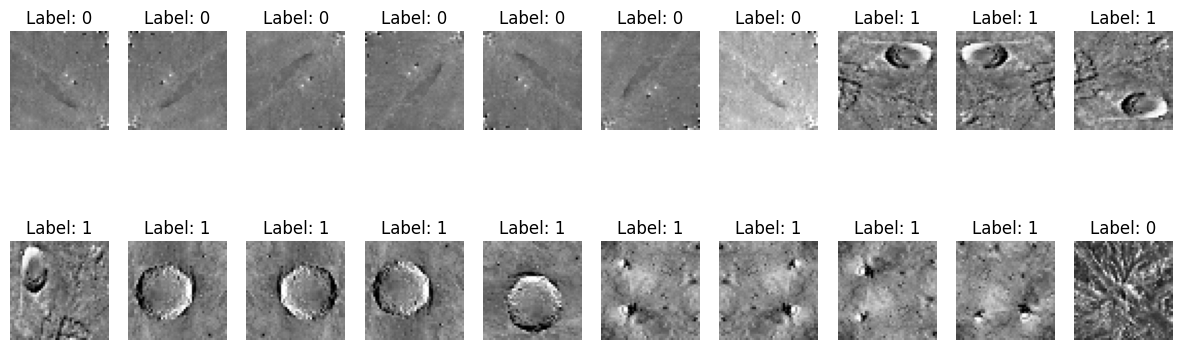

In [24]:
Xtrain_resampled, Ytrain_resampled = augment_images(Xtrain1, Ytrain1)

Xtrain_resampled = Xtrain_resampled.reshape(-1, 48, 48, 1)

print(Xtrain1.shape)
print(Xtrain_resampled.shape)

unique, counts = np.unique(Ytrain_resampled, return_counts=True)
unique1, counts1 = np.unique(Ytrain1, return_counts=True)
print(Ytrain1)
print("Quantity of 0s:", counts1[0])  # Assuming 0 is the first unique value
print("Quantity of 1s:", counts1[1])  # Assuming 1 is the second unique value

print("Quantity of 0s:", counts[0])  # Assuming 0 is the first unique value
print("Quantity of 1s:", counts[1])  # Assuming 1 is the second unique value

plot_images(Xtrain_resampled, Ytrain_resampled, extra=1)

## Build CNNs

### CNN

In [8]:
# Build a simple CNN model
def build_model_CNN():
    model_CNN = Sequential([
        Input(shape=(48, 48, 1)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),

        Dense(256, activation='relu'),
        Dropout(0.5), # model summary

        Dense(2, activation='softmax')
    ])
    # Compile the model
    model_CNN.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
    return model_CNN

## Train the models

Callbacks

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=1e-5)

### CNN

In [37]:
# Function to train the model using cross-validation
def model_cross_validation(X, Y, n_splits=5, epochs=50, batch_size=32):
    kf = KFold(n_splits=n_splits)
    best_f1 = 0

    for train_index, val_index in kf.split(X):
        print(f"Training new fold")
        y_train_cat = to_categorical(Y)
        y_val_cat = to_categorical(Y)

        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y_train_cat[train_index], y_val_cat[val_index]

        model = build_model_CNN()

        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size,
                  validation_data=(X_val_fold, y_val_fold),
                  callbacks=[early_stopping, reduce_lr])

        y_pred = model.predict(X_val_fold)
        y_pred = np.argmax(y_pred, axis=1)
        y_val_fold = np.argmax(y_val_fold, axis=1)

        f1 = f1_score(y_val_fold, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            model.save('best_model.keras')

    return best_f1

## Evaluation of the models

### CNN

In [38]:
best_f1 = model_cross_validation(Xtrain_resampled, Ytrain_resampled, n_splits=5, epochs=50, batch_size=32)
print(f"Best F1 score: {best_f1}")

Training new fold
Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8335 - loss: 0.4089 - val_accuracy: 0.6897 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9051 - loss: 0.2373 - val_accuracy: 0.7355 - val_loss: 0.7905 - learning_rate: 0.0010
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9320 - loss: 0.1751 - val_accuracy: 0.6851 - val_loss: 1.1392 - learning_rate: 0.0010
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9497 - loss: 0.1306 - val_accuracy: 0.9083 - val_loss: 0.2497 - learning_rate: 0.0010
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9576 - loss: 0.1058 - val_accuracy: 0.6108 - val_loss: 2.5974 - learning_rate: 0.0010
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9717 - loss: 0.0747 - val_accuracy: 0.8264 - val_loss: 0.6719 - learning_rate: 0.0010
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accur

In [39]:
# Load the best model
best_model = load_model('best_model.keras')
best_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_64               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_64 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_65               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_65 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_66               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_66 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_67               │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_67 (MaxPooling2D)      │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_16          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,840,648 (22.28 MB)

 Trainable params: 1,946,242 (7.42 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 3,892,486 (14.85 MB)

### Final predictions

In [40]:
Xtest1 = Xtest1.reshape(-1, 48, 48, 1)
predY_final = best_model.predict(Xtest1)
predY_classes_final = np.argmax(predY_final, axis=1)

# Save the predictions with np
np.save('predY_classes_final.npy', predY_classes_final)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
